In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)

In [4]:
(ds_train,ds_test),ds_info = tfds.load(
    "mnist",
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True

)

In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\rumma\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }

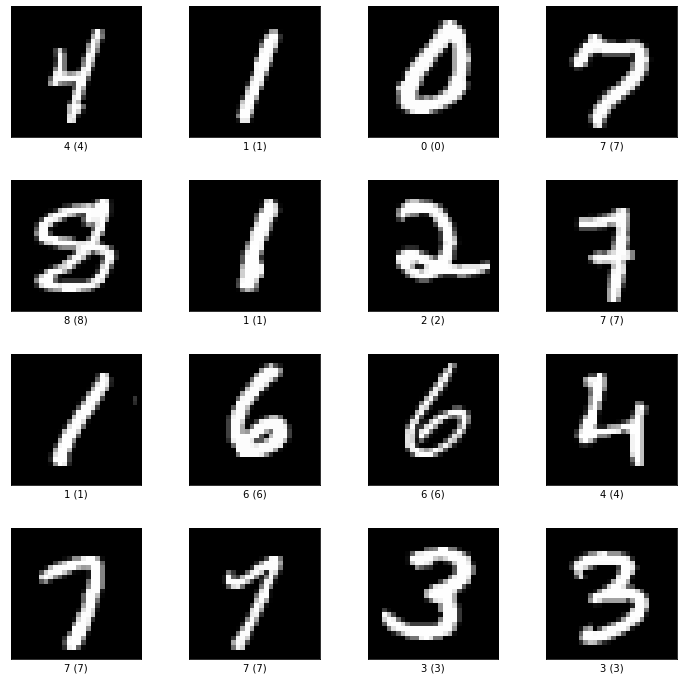

In [6]:
#some examples of the data set
fig = tfds.show_examples(ds_train,ds_info,rows=4,cols=4)

In [8]:
def normalize_img(image,label):
    #normalize images
    return tf.cast(image,tf.float32)/255.0,label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(128)
ds_test = ds_train.prefetch(AUTOTUNE)

In [10]:
model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)


In [12]:
model.fit(ds_train, epochs=5, verbose=2)

Epoch 1/5
469/469 - 16s - loss: 0.2640 - accuracy: 0.9291 - 16s/epoch - 35ms/step
Epoch 2/5
469/469 - 13s - loss: 0.0839 - accuracy: 0.9765 - 13s/epoch - 28ms/step
Epoch 3/5
469/469 - 13s - loss: 0.0583 - accuracy: 0.9837 - 13s/epoch - 28ms/step
Epoch 4/5
469/469 - 13s - loss: 0.0460 - accuracy: 0.9863 - 13s/epoch - 28ms/step
Epoch 5/5
469/469 - 13s - loss: 0.0372 - accuracy: 0.9892 - 13s/epoch - 27ms/step


In [ ]:
#IMDB_reviews dataset

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\rumma\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteKV8GQT\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\rumma\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteKV8GQT\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\rumma\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteKV8GQT\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\rumma\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [14]:
tokenizer = tfds.features.text.Tokenizer()

AttributeError: module 'tensorflow_datasets.core.features' has no attribute 'text'

In [ ]:

def build_vocabulary():
    vocabulary = set()
    for text, _ in ds_train:
        vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
    return 

In [ ]:
vocabulary = build_vocabulary()

encoder = tfds.features.text.TokenTextEncoder(
    list(vocabulary), oov_token="<UNK>", lowercase=True, tokenizer=tokenizer
)

In [ ]:
def my_enc(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label


In [ ]:
def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(
        my_enc, inp=[text, label], Tout=(tf.int64, tf.int64)
    )

    # `tf.data.Datasets` work best if all components have a shape set
    #  so set the shapes manually:
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.padded_batch(32, padded_shapes=([None], ()))
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(encode_map_fn)
ds_test = ds_test.padded_batch(32, padded_shapes=([None], ()))


In [ ]:
model = keras.Sequential(
    [
        layers.Masking(mask_value=0),
        layers.Embedding(input_dim=len(vocabulary) + 2, output_dim=32),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1),
    ]
)

In [ ]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=["accuracy"],
)


In [ ]:
model.fit(ds_train, epochs=15, verbose=2)
